In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
import statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [2]:
stock_data = pd.read_csv('AAPL.csv', sep = ',', index_col = 'Date')
#dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
#stock_data = pd.read_csv('AAPL.csv', sep=',', index_col='Date', parse_dates=['Date'], date_parser=dateparse)
df_close = stock_data['Close']
df_close.index = pd.to_datetime(df_close.index)

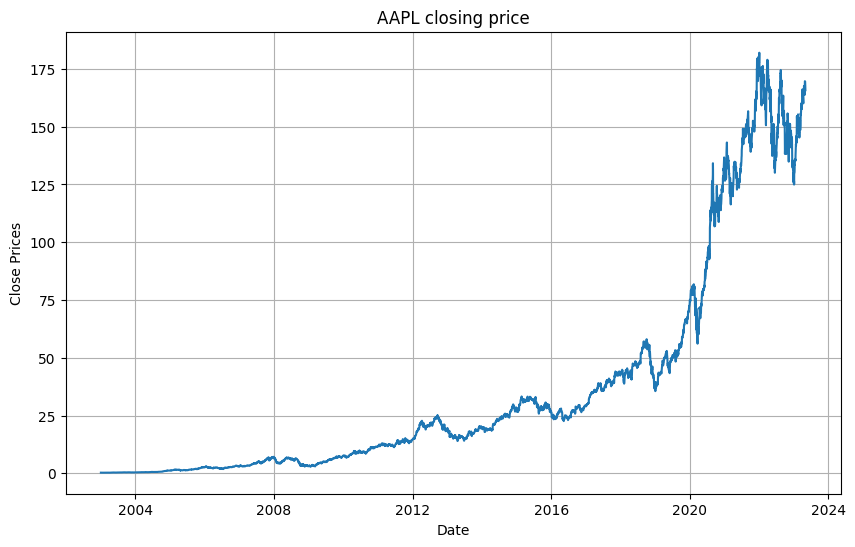

In [3]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(df_close)
plt.title('AAPL closing price')
plt.show()

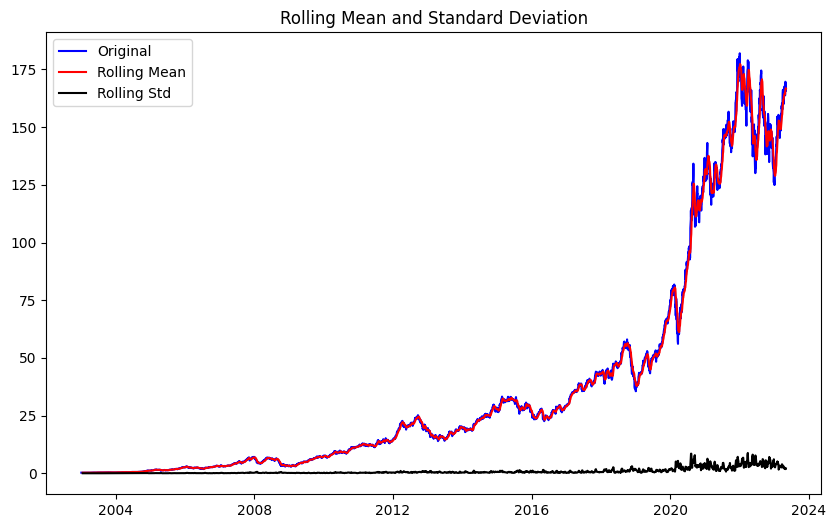

Results of dickey fuller test
Test Statistics                   1.653866
p-value                           0.998011
No. of lags used                 33.000000
Number of observations used    5086.000000
critical value (1%)              -3.431636
critical value (5%)              -2.862108
critical value (10%)             -2.567073
dtype: float64


In [4]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries, autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(df_close)

<Figure size 1000x600 with 0 Axes>

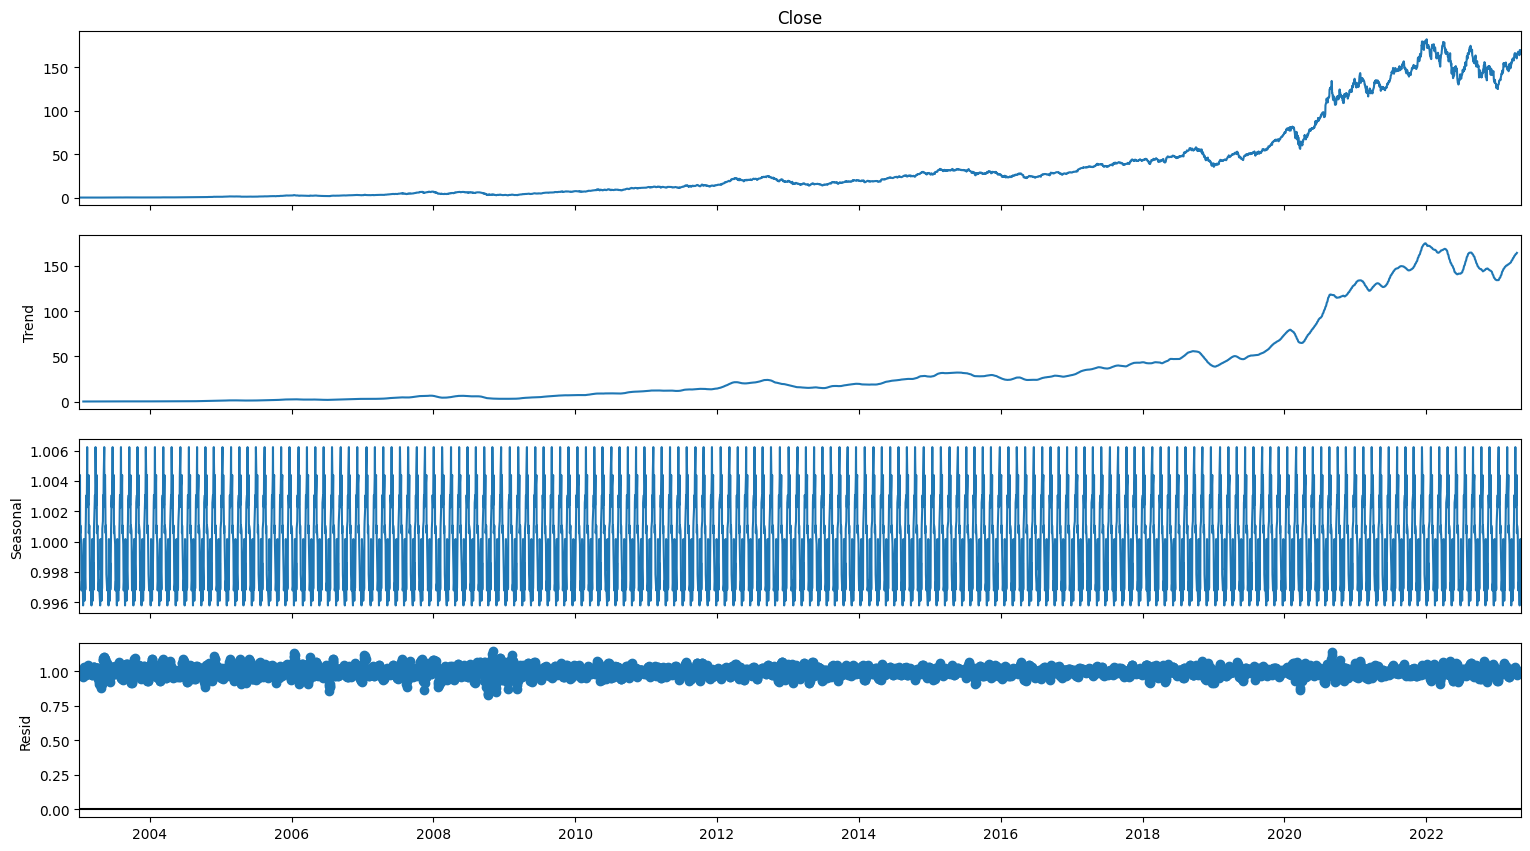

In [5]:
#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.

result = statsmodels.tsa.seasonal.seasonal_decompose(df_close, model='multiplicative', period = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


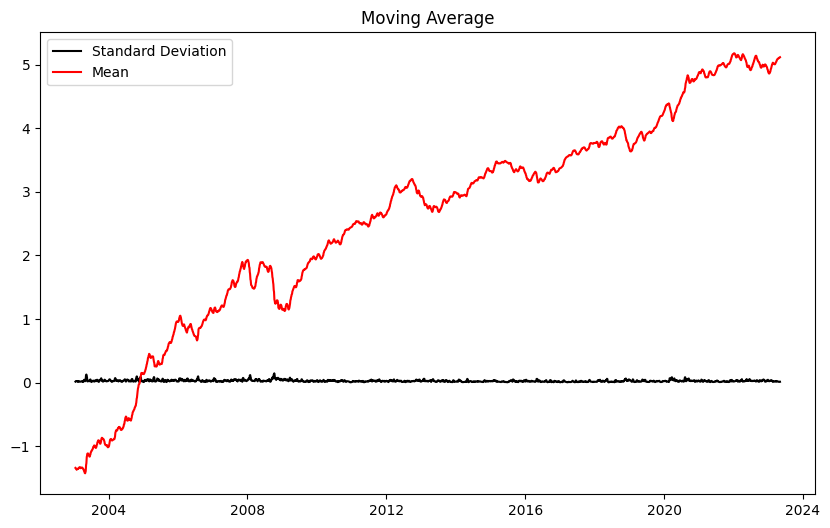

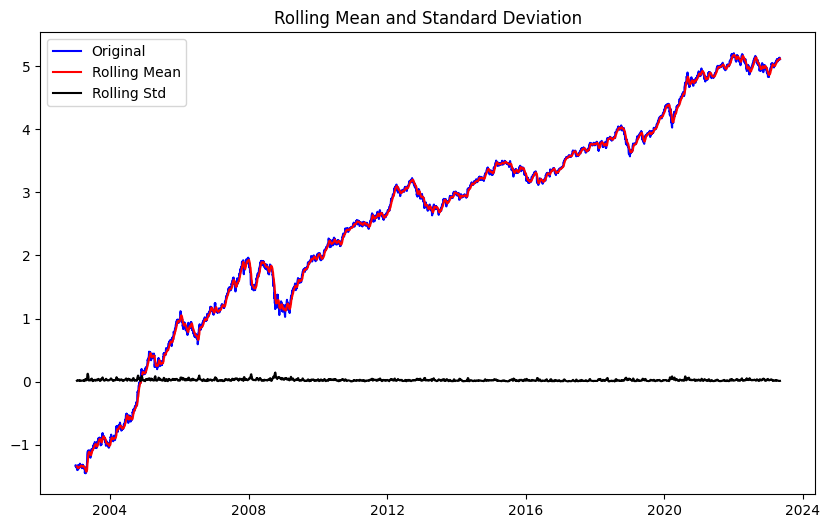

Results of dickey fuller test
Test Statistics                  -2.276307
p-value                           0.179723
No. of lags used                 16.000000
Number of observations used    5103.000000
critical value (1%)              -3.431632
critical value (5%)              -2.862107
critical value (10%)             -2.567072
dtype: float64


In [6]:
#if not stationary then eliminate trend
#Eliminate trend

rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)

moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()

plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

test_stationarity(df_log)

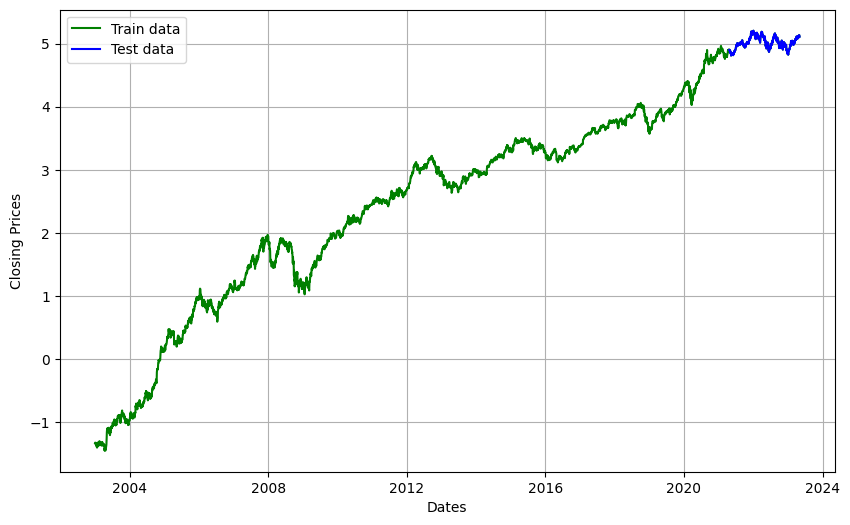

In [7]:
#split data into train and training set

train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-22331.597, Time=0.44 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-22332.327, Time=0.28 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-22332.411, Time=0.74 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-22315.336, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-22329.754, Time=1.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-22331.349, Time=0.47 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-22328.418, Time=2.21 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-22315.270, Time=0.27 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 5.729 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 4605
Model:               SARIMAX(0, 1, 1)   Log Likelihood               11169.206
Date:                Sat, 06 May 2023   AIC                         -22332.411
Time:               

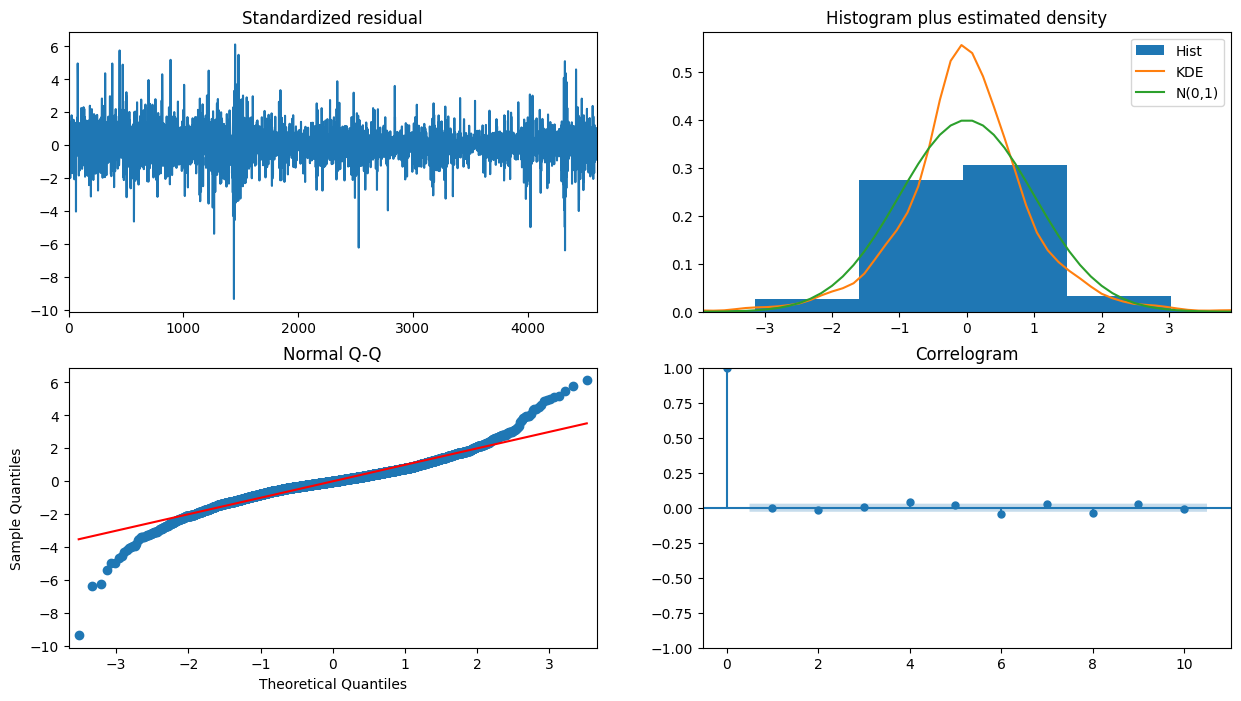

In [8]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())

model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [9]:
#Modeling

train_data.index = pd.DatetimeIndex(train_data.index).to_period('D')

model = ARIMA(train_data, order=(0,1,1))  
fitted = model.fit()  
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 4605
Model:                 ARIMA(0, 1, 1)   Log Likelihood               11159.635
Date:                Sat, 06 May 2023   AIC                         -22315.270
Time:                        01:35:18   BIC                         -22302.401
Sample:                    01-07-2003   HQIC                        -22310.741
                         - 04-22-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0204      0.010     -2.104      0.035      -0.039      -0.001
sigma2         0.0005   4.94e-06     92.859      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.09   Jarque-

In [13]:
fitted

In [11]:
# Forecast
Y_test_log = fitted.forecast(len(test_data))


In [12]:
Y_test_log

2015-08-17    4.882585
2015-08-18    4.882585
2015-08-19    4.882585
2015-08-20    4.882585
2015-08-21    4.882585
                ...   
2017-01-05    4.882585
2017-01-06    4.882585
2017-01-07    4.882585
2017-01-08    4.882585
2017-01-09    4.882585
Freq: D, Name: predicted_mean, Length: 512, dtype: float64